<div class="title">Regularized Linear Models</div>
<div class="subtitle">Machine Learning</div>
<div class="author">Carlos María Alaíz Gudín &mdash; Universidad Autónoma de Madrid</div>

---

**Configuration**

This cell defines the general configuration of Jupyter Notebook.

In [1]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

This cell imports the packages to be used.

In [2]:
# Standard packages.
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import lars_path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import sys
import warnings

# Custom packages.
from ml import (
	fit_polylinear_regression,
	generate_dataset_square,
	generate_dataset_uninformative,
	plot_dataset,
	plot_polylinear_model,
	pred_polylinear_regression,
)

# Initialisations.
matplotlib.rc("figure", figsize=(15, 5))
seed = 123
sys.dont_write_bytecode = True
warnings.filterwarnings("ignore", category=Warning)

# Regularized Linear Models

## The Need of Regularization

In this section, a 1-dimensional problem is solved by generating polynomial features.
In particular, instead of predicing $y$ using only $x$, it will be predicted using $x$, $x^2$, $x^3$...
The number of such features is obviously related with the complexity of the model.

### Dataset

The dataset is a deterministic function $y = x^2$ plus some noise.
The small number of patterns can lead to over-fitting easily.

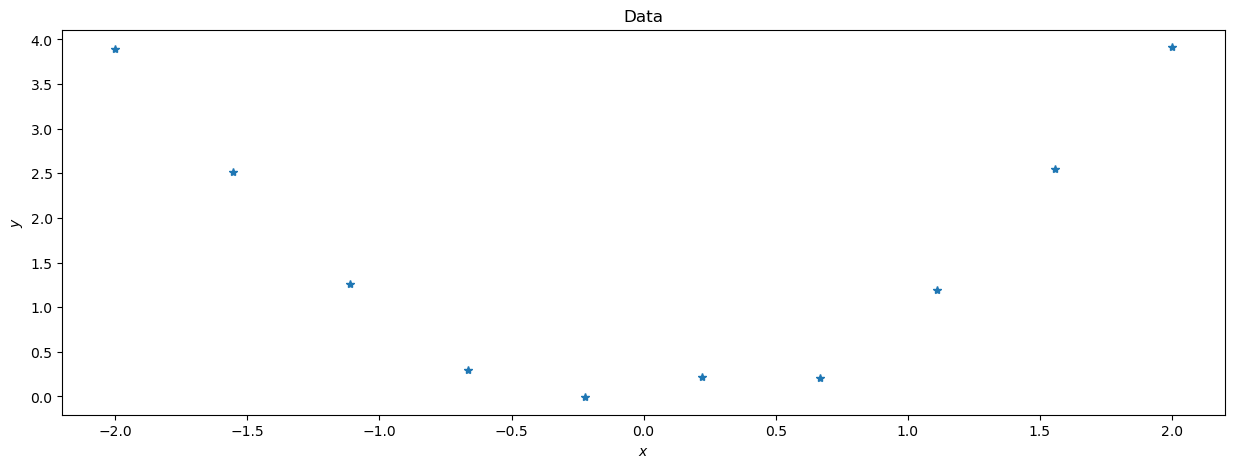

In [3]:
x, y = generate_dataset_square(seed)
plot_dataset(x, y)

### Estimation with Polynomial Features

The following cell trains a linear model with the polynomial features $(x^1, x^2, \dotsc, x^d)$.

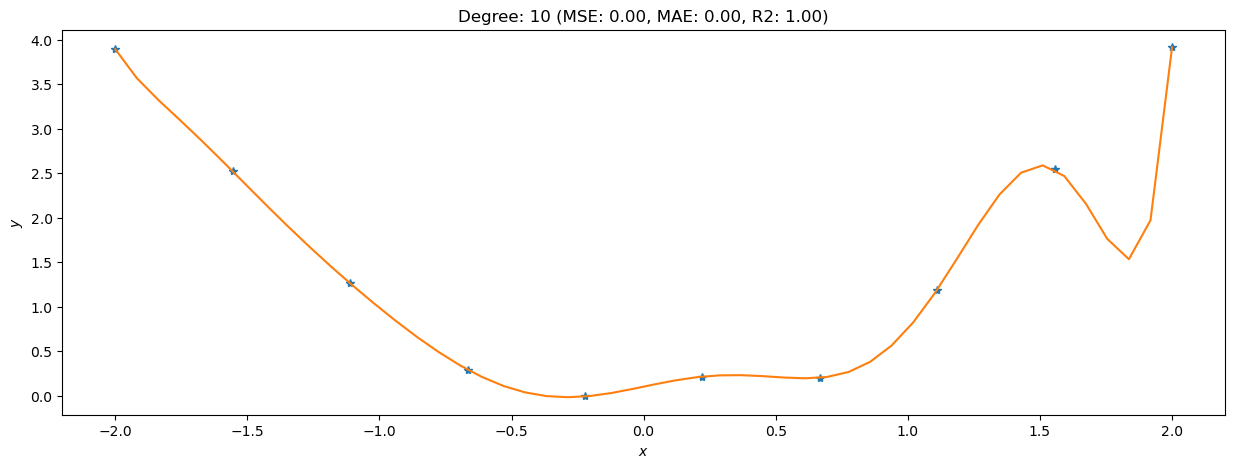

In [8]:
################################################################################
# The degree of the model can be modified here.
degree = 10
################################################################################

model = fit_polylinear_regression(x, y, degree)
plot_polylinear_model(x, y, model)

<div class="qst">

* What happens when `degree = 1`?
* And when `degree = 10`?
* What is the optimal value of `degree`?
  Is it coherent with the way the dataset was generated?

</div>

| Degree | MSE | MAE | R^2 |
| -----| -----| -----| -----|
| 1 | 2.08 | 1.29 | 0.00|
| 10 | 0.00 | 0.00 |1.00|

Cuando `degree = 1`, el modelo es una línea recta, y ningún punto se encuentra encima. Algunos puntos tienen un error positivo y otros uno negativo, es decir, están por encima o por debajo respectivamente.
Cuando `degree = 10`, el modelo sigue una especie de parábola que a valores grandes de x muestra una desviación, ya que está sobreajustado. Con `degree = 2` queda una parábola perfecta.

### Regularization Path

A (discrete) regularization path can be built for the different values of the degree, and the train and test errors can be compared.
In order to do so, a large test set is generated to evaluate the model.

In [9]:
x = x
y = y
x_te, y_te = generate_dataset_square(seed, 10 * len(x))

degree_vec = np.arange(1, len(x))

mse_tr = np.zeros(len(degree_vec))
mse_te = np.zeros(len(degree_vec))
for i_deg in range(len(degree_vec)):
    model = fit_polylinear_regression(x, y, degree_vec[i_deg])
    mse_tr[i_deg] = mean_squared_error(y, pred_polylinear_regression(model, x))
    mse_te[i_deg] = mean_squared_error(y_te, pred_polylinear_regression(model, x_te))

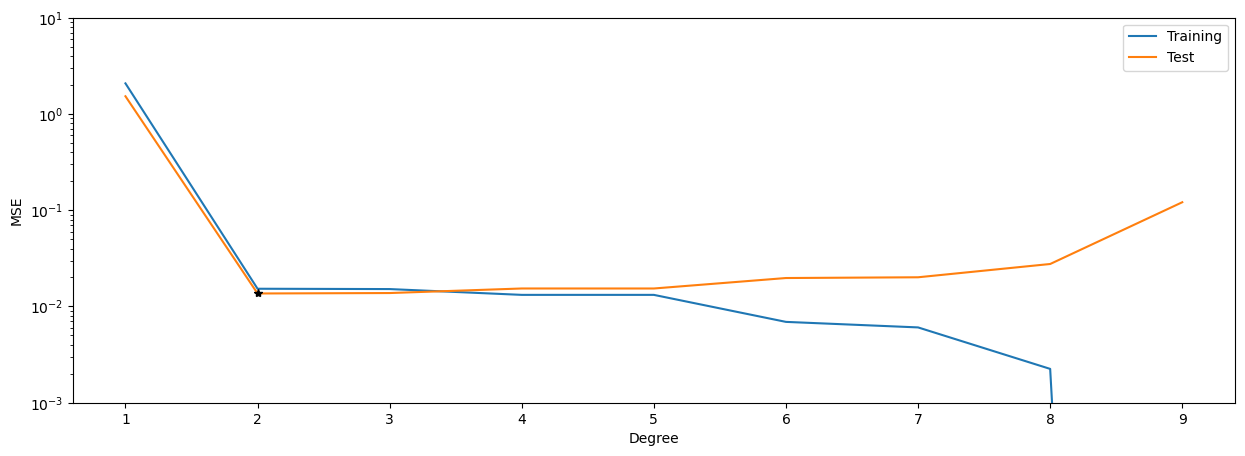

In [10]:
plt.plot(degree_vec, mse_tr, label="Training")
plt.plot(degree_vec, mse_te, label="Test")

i_opt = np.argmin(mse_te)
plt.semilogy(degree_vec[i_opt], mse_te[i_opt], "k*")

plt.xlabel("Degree")
plt.ylabel("MSE")
plt.ylim([10**-3, 10**1])
plt.legend()
plt.show()

<div class="qst">

* What is the optimal value according to this regularization path?
* Does it match the intuition?

→ [Questionnaire](https://posgrado.uam.es/mod/quiz/view.php?id=998396)
</div>

Según el gráfico, el valor óptimo es en 2 grados. A partir de 5, el MSE tiende a 0 para el entrenamiento, estando así sobreajustándose. 

## Ridge Regression

### Dataset

This cell generates a dataset with many uninformative features.

In [ ]:
x, x_te, y, y_te = generate_dataset_uninformative(seed)
alpha_vec = np.logspace(-3, 6)

### Regularization Path

An "empirical" regularization path can be estimated by changing the regularization parameter.

In [ ]:
mse_tr = np.zeros(len(alpha_vec))
mse_te = np.zeros(len(alpha_vec))
coefs = np.zeros((len(alpha_vec), x.shape[1]))
for i_alp in range(len(alpha_vec)):
    model = Ridge(alpha_vec[i_alp])
    model.fit(x, y)
    mse_tr[i_alp] = mean_squared_error(y, model.predict(x))
    mse_te[i_alp] = mean_squared_error(y_te, model.predict(x_te))
    coefs[i_alp, :] = model.coef_

In [ ]:
plt.semilogx(alpha_vec, mse_tr, label="Training")
plt.semilogx(alpha_vec, mse_te, label="Test")

i_opt = np.argmin(mse_te)
plt.semilogx(alpha_vec[i_opt], mse_te[i_opt], "k*")

plt.xlabel("$\\alpha$")
plt.ylabel("MSE")
plt.legend()
plt.show()

The evolution of the coefficients illustrates the effect of the regularizer.

In [ ]:
plt.semilogx(alpha_vec, coefs)

plt.title("Ridge Regression Regularization Path")
plt.xlabel("$\\alpha$")
plt.ylabel("Weight")
plt.show()

<div class="qst">

* Is this evolution intuitive?
* Does it match the theory?

→ [Questionnaire](https://posgrado.uam.es/mod/quiz/view.php?id=998399)
</div>

### Cross-Validation

An automatic search of the parameters can be done using the `GridSearchCV` class.

In [ ]:
################################################################################
gs = GridSearchCV(Ridge(), cv=5, param_grid={"alpha": alpha_vec})
gs.fit(x, y)
print("Best Parameter: {:.2g}".format(gs.best_params_["alpha"]))
print("Performance: {:.4f}".format(gs.score(x_te, y_te)))
################################################################################

<div class="qst inspect">

* Is the optimal value similar to the one obtained above?

</div>

## Lasso

The same procedure can be repeated for the Lasso model, although there are specific ways of computing efficiently its regularization path.

In [ ]:
x, x_te, y, y_te = generate_dataset_uninformative(seed)
alpha_vec = np.logspace(-3, 6)

### Regularization Path

In [ ]:
mse_tr = np.zeros(len(alpha_vec))
mse_te = np.zeros(len(alpha_vec))
coefs = np.zeros((len(alpha_vec), x.shape[1]))
for i_alp in range(len(alpha_vec)):
    model = Lasso(alpha_vec[i_alp], max_iter=5000)
    model.fit(x, y)
    mse_tr[i_alp] = mean_squared_error(y, model.predict(x))
    mse_te[i_alp] = mean_squared_error(y_te, model.predict(x_te))
    coefs[i_alp, :] = model.coef_

In [ ]:
plt.semilogx(alpha_vec, mse_tr, label="Training")
plt.semilogx(alpha_vec, mse_te, label="Test")

i_opt = np.argmin(mse_te)
plt.semilogx(alpha_vec[i_opt], mse_te[i_opt], "k*")

plt.xlabel("$\\alpha$")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [ ]:
plt.semilogx(alpha_vec, coefs)

plt.title("Lasso Regularization Path")
plt.xlabel("$\\alpha$")
plt.ylabel("Weight")
plt.show()

This cell computes the "theoretical" regularization path of Lasso.

In [ ]:
_, _, coefs = lars_path(x, y, method="lasso")

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle="dashed")

plt.title("Lasso Regularization Path")
plt.xlabel("$\\frac{\\|w\\|_1}{\\max_j\\|w_j\\|}$")
plt.ylabel("Weight")
plt.axis("tight")
plt.show()

### Cross-Validation

An automatic search of the parameters can be done using the `GridSearchCV` class.

In [ ]:
################################################################################
gs = GridSearchCV(Lasso(max_iter=5000), cv=5, param_grid={"alpha": alpha_vec})
gs.fit(x, y)
print("Best Parameter: {:.2g}".format(gs.best_params_["alpha"]))
print("Performance: {:.4f}".format(gs.score(x_te, y_te)))
################################################################################

The selected features can be inspected in the optimal model.

In [ ]:
################################################################################
print(gs.best_estimator_.sparse_coef_)
################################################################################

<div class="qst inspect">

* Is there any sparsity?

→ [Questionnaire](https://posgrado.uam.es/mod/quiz/view.php?id=998400)
</div>

## Elastic-Net

In [ ]:
x, x_te, y, y_te = generate_dataset_uninformative(seed)
alpha_vec = np.logspace(-3, 6)

For Elastic-Net, two hyper-parameters have to be set, and hence plotting a regularization path is not trivial, and tuning the model is the standard approach.

In [ ]:
################################################################################
gs = GridSearchCV(
    ElasticNet(max_iter=5000),
    cv=5,
    param_grid={"alpha": alpha_vec, "l1_ratio": [0, 0.05, 0.5, 0.95, 1.0]},
)
gs.fit(x, y)
print("Best Regularization Parameter: {:.2g}".format(gs.best_params_["alpha"]))
print("Best Mixture Parameter: {:.2g}".format(gs.best_params_["l1_ratio"]))
print("Performance: {:.4f}".format(gs.score(x_te, y_te)))
################################################################################

<div class="qst">

* Is in this case Elastic-Net different from Lasso?
  Why?

→ [Questionnaire](https://posgrado.uam.es/mod/quiz/view.php?id=998401)
</div>